### Import Librerie e Configurazione

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import community as community_louvain # Assicurati di aver installato python-louvain
from networkx.algorithms.clique import max_weight_clique

# Impostazioni grafiche globali
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- FUNZIONI DI UTILTÀ (Per evitare codice ridondante) ---

def print_top_bottom(metric_dict, metric_name, k=10):
    """
    Stampa una classifica pulita dei primi k e ultimi k personaggi 
    per una determinata metrica.
    """
    # Ordina il dizionario dal valore più alto al più basso
    sorted_items = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n--- {metric_name.upper()} ---")
    print(f"🏆 TOP {k} Personaggi:")
    for i, (node, val) in enumerate(sorted_items[:k], 1):
        print(f"{i}. {node}: {val:.4f}")
        
    print(f"\n📉 BOTTOM {k} Personaggi (con valore > 0):")
    # Filtra i valori a zero per mostrare i personaggi periferici ma attivi
    non_zero = [x for x in sorted_items if x[1] > 0]
    for i, (node, val) in enumerate(non_zero[-k:], 1):
        print(f"{len(non_zero)-k+i}. {node}: {val:.4f}")

def plot_distribution(metric_dict, title, xlabel):
    """
    Genera un istogramma rosso per visualizzare la distribuzione della metrica.
    """
    plt.figure()
    sns.histplot(list(metric_dict.values()), kde=True, color='firebrick', bins=30, alpha=0.6)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Frequenza (Numero di Personaggi)", fontsize=12)
    plt.show()

print("✅ Librerie importate e funzioni configurate.")

✅ Librerie importate e funzioni configurate.


### Caricamento dati e Preprocessing

In [2]:
# --- CARICAMENTO DEL DATASET ---
filename = "data/got/GoT_cum.graphml"

if os.path.exists(filename):
    # Caricamento del grafo grezzo
    G = nx.read_graphml(filename)
    
    # --- PREPROCESSING FONDAMENTALE ---
    # Sostituisce gli ID interni (es. 'n0') con i nomi veri (es. 'Jon Snow')
    # contenuti nell'attributo 'label' del file graphml.
    mapping = nx.get_node_attributes(G, 'label')
    G = nx.relabel_nodes(G, mapping)
    
    print(f"✅ Grafo '{filename}' caricato e rinominato correttamente.")
    print(f"   Nodi Totali: {G.number_of_nodes()}")
    print(f"   Archi Totali: {G.number_of_edges()}")
    
else:
    print(f"❌ Errore: Il file {filename} non è stato trovato nella cartella.")

✅ Grafo 'data/got/GoT_cum.graphml' caricato e rinominato correttamente.
   Nodi Totali: 338
   Archi Totali: 940


### Analisi Esplorativa


🔹 --- ANALISI ESPLORATIVA ---
• Densità della Rete: 0.01650
• Grafo Connesso: No
• Numero Componenti Connesse: 5
• Giant Component: 329 nodi (97.3% del totale)

📏 Misure Topologiche (sulla componente connessa principale):
• Diametro (Distanza massima): 8
• Raggio (Eccentricità minima): 4
• Lunghezza media percorso (Average Path Length): 3.42
• Coefficiente di Clustering Medio (Pesato): 0.0141


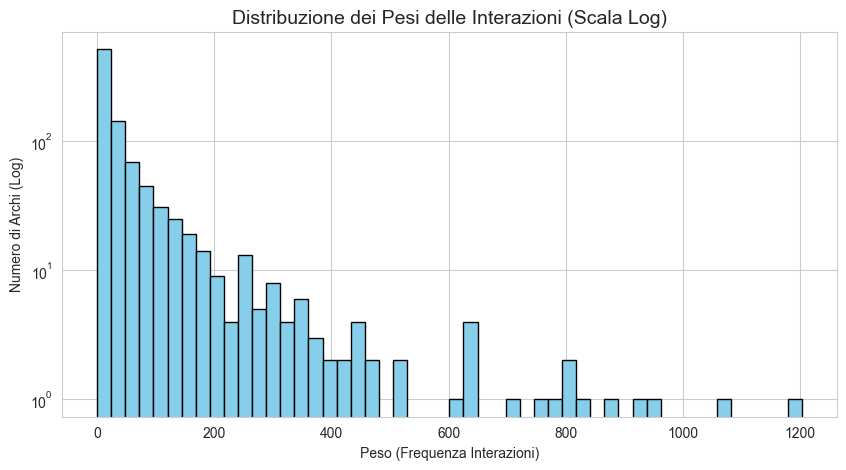

In [3]:
print("\n🔹 --- ANALISI ESPLORATIVA ---")

# 1. DENSITÀ
# Misura quanto è fitta la rete rispetto a una rete completa (dove tutti parlano con tutti)
density = nx.density(G)
print(f"• Densità della Rete: {density:.5f}")

# 2. CONNESSIONE E COMPONENTI
is_connected = nx.is_connected(G)
print(f"• Grafo Connesso: {'Sì' if is_connected else 'No'}")

if not is_connected:
    components = list(nx.connected_components(G))
    print(f"• Numero Componenti Connesse: {len(components)}")
    
    # Identificazione della Giant Component (S) per i calcoli successivi
    largest_cc = max(components, key=len)
    S = G.subgraph(largest_cc).copy()
    print(f"• Giant Component: {S.number_of_nodes()} nodi ({S.number_of_nodes()/G.number_of_nodes():.1%} del totale)")
else:
    S = G

# 3. MISURE TOPOLOGICHE (Calcolate sulla Giant Component S)
# Diametro e raggio richiedono un grafo connesso, quindi usiamo S
print("\n📏 Misure Topologiche (sulla componente connessa principale):")
print(f"• Diametro (Distanza massima): {nx.diameter(S)}")
print(f"• Raggio (Eccentricità minima): {nx.radius(S)}")
print(f"• Lunghezza media percorso (Average Path Length): {nx.average_shortest_path_length(S):.2f}")

# 4. CLUSTERING
# Misura la tendenza a formare gruppi chiusi (triangoli)
# Usiamo il clustering pesato ('weight') per considerare l'intensità delle relazioni
avg_clust_w = nx.average_clustering(G, weight='weight')
print(f"• Coefficiente di Clustering Medio (Pesato): {avg_clust_w:.4f}")

# 5. DISTRIBUZIONE DEI PESI (Grafico)
# Mostra se ci sono tante relazioni deboli o poche forti
weights = [data['weight'] for u, v, data in G.edges(data=True)]
plt.figure(figsize=(10, 5))
# Usiamo scala logaritmica perché spesso in queste reti ci sono enormi differenze di peso
plt.hist(weights, bins=50, color='skyblue', edgecolor='black', log=True)
plt.title("Distribuzione dei Pesi delle Interazioni (Scala Log)", fontsize=14)
plt.xlabel("Peso (Frequenza Interazioni)")
plt.ylabel("Numero di Archi (Log)")
plt.show()

### Analisi delle Misure di Centralità


🔹 --- CAPITOLO 4: MISURE DI CENTRALITÀ ---

--- DEGREE CENTRALITY ---
🏆 TOP 10 Personaggi:
1. Tyrion Lannister: 0.1840
2. Arya Stark: 0.1246
3. Jaime Lannister: 0.1128
4. Jon Snow: 0.1098
5. Cersei Lannister: 0.1098
6. Sansa Stark: 0.1068
7. Theon Greyjoy: 0.1039
8. Joffrey Baratheon: 0.1039
9. Catelyn Stark: 0.1039
10. Petyr Baelish: 0.1009

📉 BOTTOM 10 Personaggi (con valore > 0):
329. Timett: 0.0030
330. Ralf Kenning: 0.0030
331. Reginald Lannister: 0.0030
332. Septon: 0.0030
333. Stark messenger: 0.0030
334. Ryger Rivers: 0.0030
335. Stevron Frey: 0.0030
336. Whore (Mother of Dragons): 0.0030
337. Yunkai'i slave #1: 0.0030
338. Yunkai'i slave #2: 0.0030


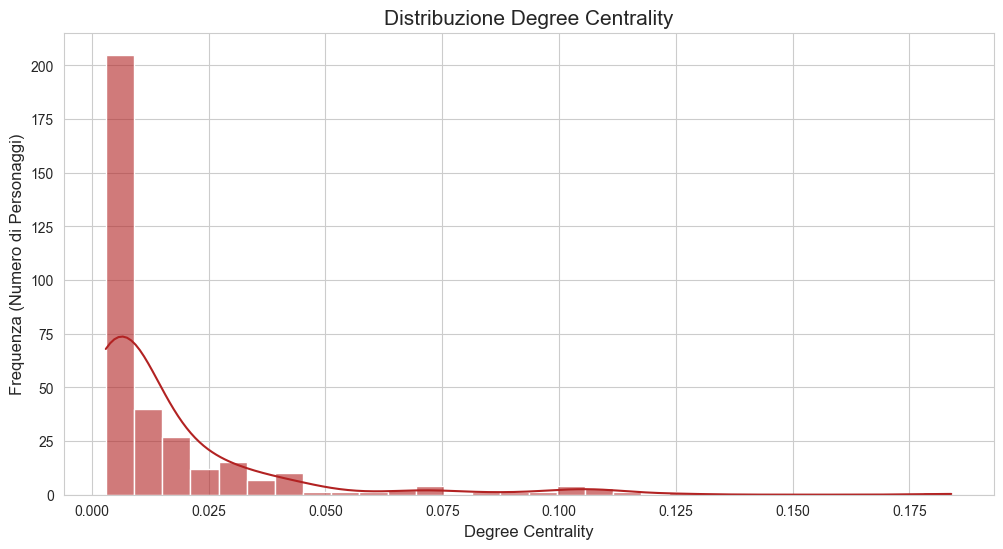


--- CLOSENESS CENTRALITY ---
🏆 TOP 10 Personaggi:
1. Tyrion Lannister: 0.4709
2. Jon Snow: 0.4297
3. Jaime Lannister: 0.4268
4. Catelyn Stark: 0.4195
5. Eddard Stark: 0.4190
6. Theon Greyjoy: 0.4062
7. Sansa Stark: 0.4041
8. Petyr Baelish: 0.4011
9. Cersei Lannister: 0.3991
10. Brandon Stark: 0.3961

📉 BOTTOM 10 Personaggi (con valore > 0):
329. Jack Bulwer: 0.1587
330. Gared: 0.0059
331. Waymar Royce: 0.0059
332. Will: 0.0059
333. Dwarf Hunter #1: 0.0030
334. Dwarf Hunter #2: 0.0030
335. Lannister guardsman #2: 0.0030
336. Rennick: 0.0030
337. Yunkai'i slave #1: 0.0030
338. Yunkai'i slave #2: 0.0030


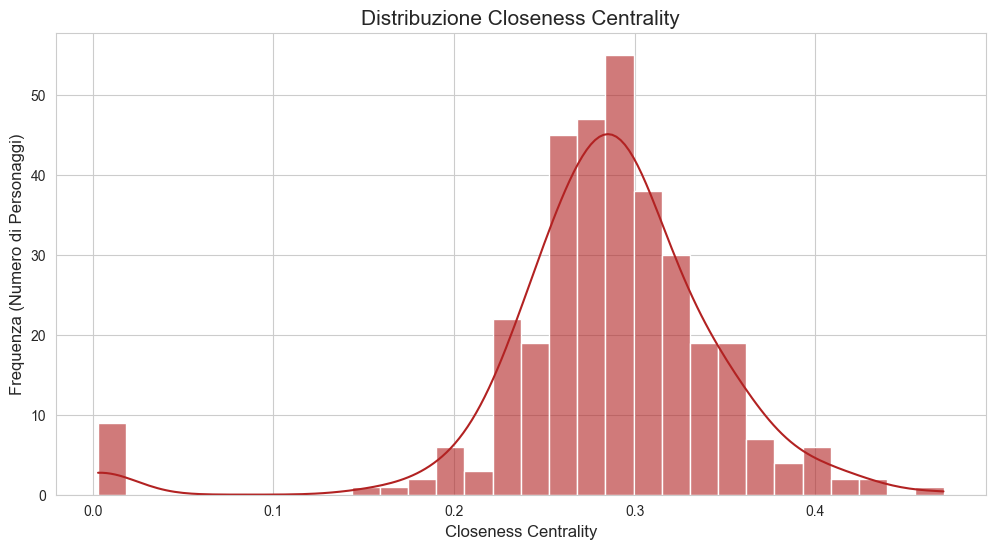


--- BETWEENNESS CENTRALITY ---
🏆 TOP 10 Personaggi:
1. Tyrion Lannister: 0.3251
2. Rodrik Cassel: 0.2825
3. Hodor: 0.2560
4. Bronn: 0.2101
5. Petyr Baelish: 0.1902
6. Myrcella Baratheon: 0.1520
7. Fighting pit announcer: 0.1517
8. Locke: 0.1469
9. Theon Greyjoy: 0.1423
10. Joffrey Baratheon: 0.1352

📉 BOTTOM 10 Personaggi (con valore > 0):
151. Stark soldier #1: 0.0002
152. Qyburn: 0.0002
153. Pypar: 0.0002
154. Bowen Marsh: 0.0002
155. Rakharo: 0.0001
156. Daario Naharis: 0.0001
157. Cressen: 0.0001
158. Marei: 0.0001
159. Wun Weg Wun Dar Wun: 0.0000
160. Gared: 0.0000


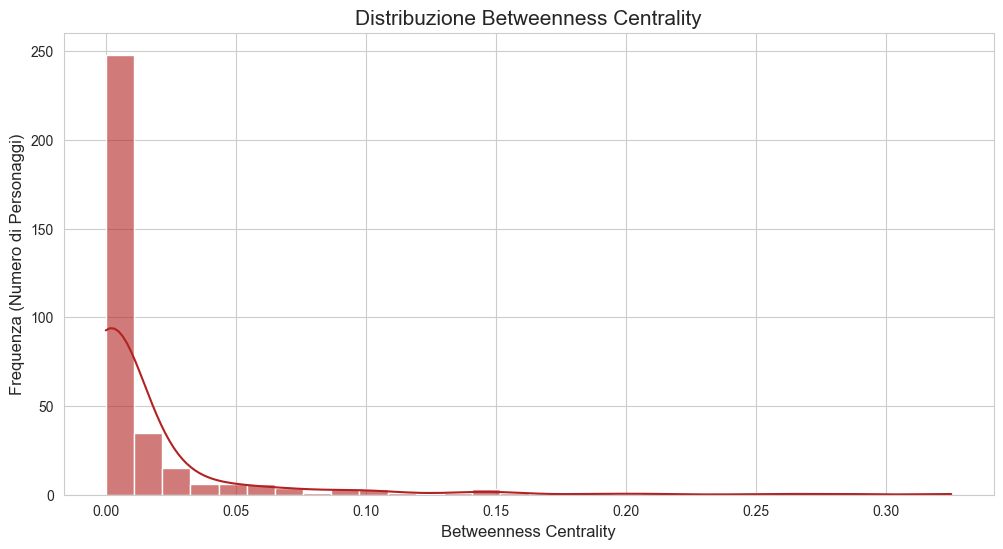


--- EIGENVECTOR CENTRALITY ---
🏆 TOP 10 Personaggi:
1. Tyrion Lannister: 0.5684
2. Cersei Lannister: 0.3747
3. Tywin Lannister: 0.2957
4. Jaime Lannister: 0.2672
5. Varys: 0.2649
6. Sansa Stark: 0.1971
7. Bronn: 0.1932
8. Petyr Baelish: 0.1913
9. Shae: 0.1763
10. Joffrey Baratheon: 0.1537

📉 BOTTOM 10 Personaggi (con valore > 0):
329. Jack Bulwer: 0.0000
330. Lannister guardsman #2: 0.0000
331. Rennick: 0.0000
332. Waymar Royce: 0.0000
333. Will: 0.0000
334. Gared: 0.0000
335. Yunkai'i slave #1: 0.0000
336. Yunkai'i slave #2: 0.0000
337. Dwarf Hunter #1: 0.0000
338. Dwarf Hunter #2: 0.0000


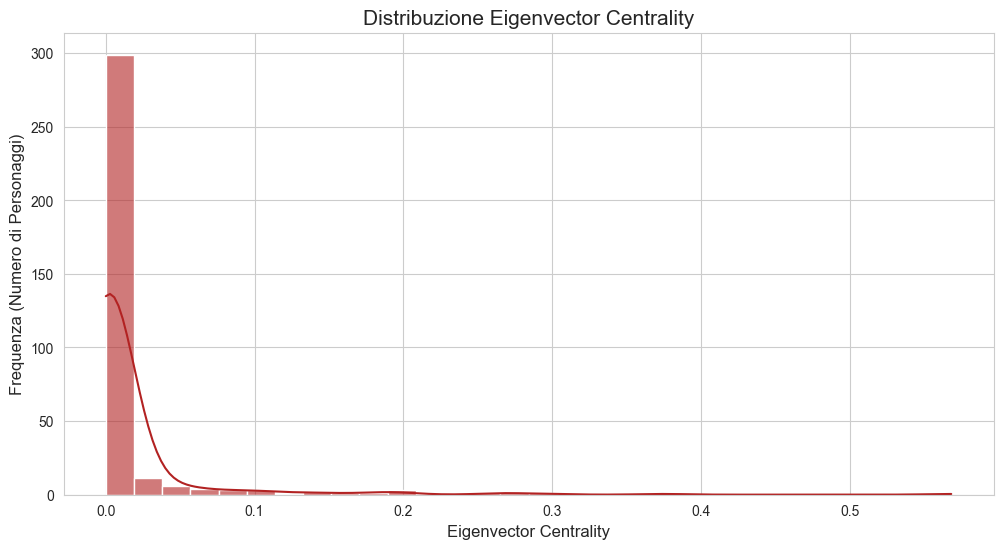

In [4]:
print("\n🔹 --- CAPITOLO 4: MISURE DI CENTRALITÀ ---")

# ==========================================
# 1. DEGREE CENTRALITY (Popolarità)
# ==========================================
# Chi ha il maggior numero di connessioni dirette
degree_cent = nx.degree_centrality(G)
print_top_bottom(degree_cent, "Degree Centrality")
plot_distribution(degree_cent, "Distribuzione Degree Centrality", "Degree Centrality")

# ==========================================
# 2. CLOSENESS CENTRALITY (Accessibilità)
# ==========================================
# Chi può raggiungere tutti gli altri nodi nel minor tempo
closeness_cent = nx.closeness_centrality(G)
print_top_bottom(closeness_cent, "Closeness Centrality")
plot_distribution(closeness_cent, "Distribuzione Closeness Centrality", "Closeness Centrality")

# ==========================================
# 3. BETWEENNESS CENTRALITY (Ponti e Broker)
# ==========================================
# Chi controlla i flussi di informazione tra gruppi diversi
# Fondamentale usare weight='weight' perché i percorsi brevi dipendono dall'intensità del legame
betweenness_cent = nx.betweenness_centrality(G, weight='weight')
print_top_bottom(betweenness_cent, "Betweenness Centrality")
plot_distribution(betweenness_cent, "Distribuzione Betweenness Centrality", "Betweenness Centrality")

# ==========================================
# 4. EIGENVECTOR CENTRALITY (Influenza)
# ==========================================
# Chi è connesso a nodi a loro volta importanti (VIP)
try:
    # Tentativo sul grafo completo
    eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')
    title_eig = "Eigenvector Centrality"
except:
    # Fallback sulla Giant Component se il grafo non converge
    print("⚠️ Calcolo Eigenvector sulla Giant Component per favorire convergenza.")
    eigenvector_cent = nx.eigenvector_centrality(S, max_iter=1000, weight='weight')
    title_eig = "Eigenvector Centrality (Giant Component)"

print_top_bottom(eigenvector_cent, title_eig)
plot_distribution(eigenvector_cent, f"Distribuzione {title_eig}", "Eigenvector Centrality")

### Analisi delle strutture e Comunità

In [5]:
print("\n🔹 --- ANALISI DELLE STRUTTURE E COMMUNITY ---")

# ==========================================
# 1. TRIADI E CLIQUE
# ==========================================
print("\n1️⃣ --- TRIADI E CLIQUE ---")
# Triadi: In un grafo non orientato, il clustering coefficient è la misura diretta della chiusura triadica
avg_clust = nx.average_clustering(G)
print(f"• Coefficiente di Clustering Medio: {avg_clust:.4f}")
print("  (Indica la probabilità che due amici di un personaggio siano anche amici tra loro)")

# Clique Massima (Il gruppo più grande dove tutti parlano con tutti)
# Nota: Usiamo la clique semplice (non pesata) per trovare la dimensione massima
cliques = list(nx.find_cliques(G))
max_clique = max(cliques, key=len)
print(f"\n• Clique Massima (Dimensione {len(max_clique)}):")
print(f"  Membri: {', '.join(max_clique)}")

# ==========================================
# 2. K-CORE (Il "Nocciolo Duro")
# ==========================================
print("\n2️⃣ --- K-CORE DECOMPOSITION ---")
# Il k-core è il sottografo in cui ogni nodo ha almeno grado k
# Troviamo il k-core massimo (il gruppo più resiliente)
core_number = nx.core_number(G)
max_k = max(core_number.values())
k_core = nx.k_core(G, k=max_k)

print(f"• Max K-Core (k={max_k}):")
print(f"  Numero Nodi nel Core: {k_core.number_of_nodes()}")
print(f"  Numero Archi nel Core: {k_core.number_of_edges()}")
print(f"  Personaggi del nucleo duro: {list(k_core.nodes())[:10]} ...") # Ne stampiamo solo 10 per brevità

# ==========================================
# 3. COMMUNITY DETECTION (Le "Casate")
# ==========================================
print("\n3️⃣ --- COMMUNITY DETECTION (LOUVAIN) ---")
# Rileviamo le comunità basandoci sui pesi delle interazioni
partition = community_louvain.best_partition(G, weight='weight', resolution=1.0)

# Organizziamo i dati per stamparli bene
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

# Ordiniamo le comunità per dimensione (numero di membri)
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

print(f"• Numero Comunità Individuate: {len(sorted_communities)}")
print("\n• Le 3 Comunità più numerose (Principali Alleanze):")
for i, (comm_id, members) in enumerate(sorted_communities[:3], 1):
    print(f"  GRUPPO {i} ({len(members)} membri):")
    # Stampiamo i primi 10 membri più importanti (per grado) di questo gruppo
    top_members = sorted(members, key=lambda x: G.degree(x), reverse=True)[:10]
    print(f"  Top membri: {', '.join(top_members)}")
    print("-" * 30)

# ==========================================
# 4. EGO NETWORK (Focus su un personaggio)
# ==========================================
target_ego = "Daenerys Targaryen" # Puoi cambiarlo con 'Jon Snow' o 'Tyrion Lannister'
print(f"\n4️⃣ --- EGO NETWORK: {target_ego.upper()} ---")

if target_ego in G:
    # Creiamo il sottografo dell'Ego (Ego + i suoi vicini)
    ego_net = nx.ego_graph(G, target_ego)
    print(f"• Dimensione della rete personale: {ego_net.number_of_nodes()} personaggi")
    print(f"• Densità della rete personale: {nx.density(ego_net):.4f}")
    
    # Chi sono i più connessi DENTRO la rete di questo personaggio?
    ego_degrees = dict(ego_net.degree(weight='weight'))
    top_allies = sorted(ego_degrees.items(), key=lambda x: x[1], reverse=True)[1:6] # Saltiamo il primo che è l'Ego stesso
    print(f"• I 5 alleati più stretti: {[n[0] for n in top_allies]}")
else:
    print(f"⚠️ Errore: Il personaggio '{target_ego}' non esiste nel grafo (controlla lo spelling).")


🔹 --- ANALISI DELLE STRUTTURE E COMMUNITY ---

1️⃣ --- TRIADI E CLIQUE ---
• Coefficiente di Clustering Medio: 0.4272
  (Indica la probabilità che due amici di un personaggio siano anche amici tra loro)

• Clique Massima (Dimensione 7):
  Membri: Renly Baratheon, Petyr Baelish, Sansa Stark, Catelyn Stark, Eddard Stark, Varys, Robert Baratheon

2️⃣ --- K-CORE DECOMPOSITION ---
• Max K-Core (k=8):
  Numero Nodi nel Core: 18
  Numero Archi nel Core: 102
  Personaggi del nucleo duro: ['Varys', 'Margaery Tyrell', 'Jaime Lannister', 'Tyrion Lannister', 'Brienne of Tarth', 'Loras Tyrell', 'Olenna Tyrell', 'Joffrey Baratheon', 'Renly Baratheon', 'Sansa Stark'] ...

3️⃣ --- COMMUNITY DETECTION (LOUVAIN) ---
• Numero Comunità Individuate: 11

• Le 3 Comunità più numerose (Principali Alleanze):
  GRUPPO 1 (92 membri):
  Top membri: Tyrion Lannister, Cersei Lannister, Sansa Stark, Joffrey Baratheon, Petyr Baelish, Eddard Stark, Tywin Lannister, Bronn, Varys, Olenna Tyrell
------------------------

### CLIQUE MASSIMA

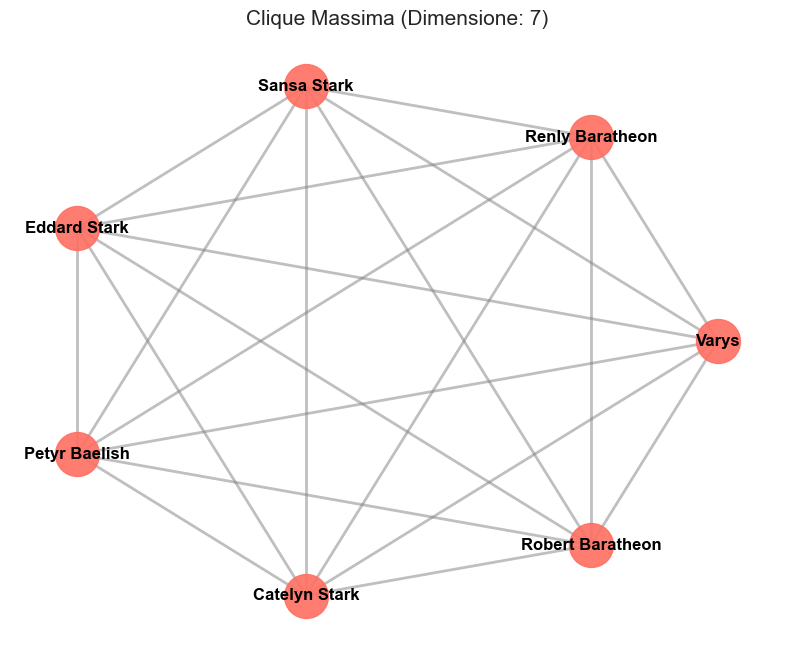

In [6]:
# --- GRAFO 1: CLIQUE MASSIMA ---
plt.figure(figsize=(10, 8))

# Trova la clique massima
cliques = list(nx.find_cliques(G))
max_clique_nodes = max(cliques, key=len)
clique_graph = G.subgraph(max_clique_nodes)

# Layout circolare (ottimo per mostrare che tutti sono collegati a tutti)
pos = nx.circular_layout(clique_graph)

# Disegno
nx.draw_networkx_nodes(clique_graph, pos, node_size=1000, node_color='#FF6F61', alpha=0.9)
nx.draw_networkx_edges(clique_graph, pos, width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(clique_graph, pos, font_size=12, font_weight='bold')

plt.title(f"Clique Massima (Dimensione: {len(max_clique_nodes)})", fontsize=15)
plt.axis('off')
plt.show()

### K-CORE

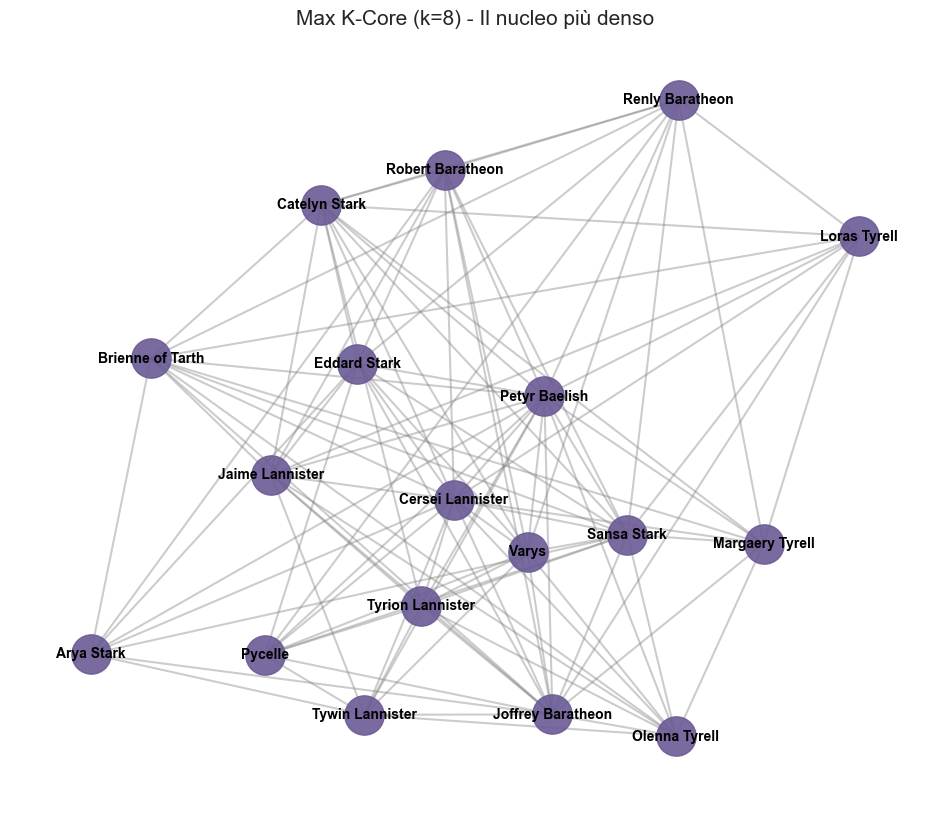

In [7]:
# --- GRAFO 2: MAX K-CORE ---
plt.figure(figsize=(12, 10))

# Calcolo K-Core massimo
core_number = nx.core_number(G)
max_k = max(core_number.values())
k_core_graph = nx.k_core(G, k=max_k)

# Layout a molla (Spring) per distribuire bene i nodi
pos = nx.spring_layout(k_core_graph, k=0.5, seed=42)

# Disegno
nx.draw_networkx_nodes(k_core_graph, pos, node_size=800, node_color='#6B5B95', alpha=0.9)
nx.draw_networkx_edges(k_core_graph, pos, width=1.5, alpha=0.4, edge_color='gray')
nx.draw_networkx_labels(k_core_graph, pos, font_size=10, font_color='black', font_weight='bold')

plt.title(f"Max K-Core (k={max_k}) - Il nucleo più denso", fontsize=15)
plt.axis('off')
plt.show()

### EGO-NETWORK

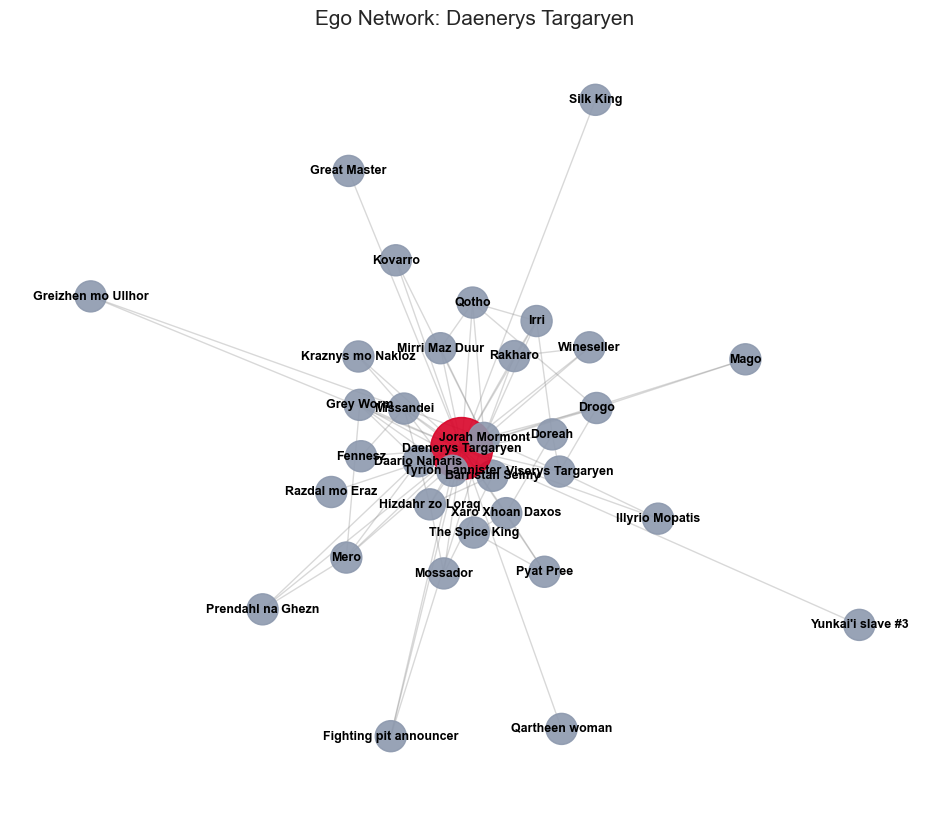

In [8]:
# --- GRAFO 3: EGO NETWORK (Daenerys) ---
plt.figure(figsize=(12, 10))

target_ego = "Daenerys Targaryen"

if target_ego in G:
    # Estrai la rete ego
    ego_graph = nx.ego_graph(G, target_ego)
    pos = nx.spring_layout(ego_graph, seed=42)
    
    # Definisci colori: Rosso per l'Ego, Blu per gli altri
    node_colors = ['#D90429' if n == target_ego else '#8D99AE' for n in ego_graph.nodes()]
    node_sizes = [2000 if n == target_ego else 500 for n in ego_graph.nodes()]
    
    # Disegno
    nx.draw_networkx_nodes(ego_graph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(ego_graph, pos, width=1, alpha=0.3, edge_color='gray')
    nx.draw_networkx_labels(ego_graph, pos, font_size=9, font_weight='bold')
    
    plt.title(f"Ego Network: {target_ego}", fontsize=15)
    plt.axis('off')
    plt.show()
else:
    print(f"Il personaggio {target_ego} non è nel grafo.")

### COMMUNITY

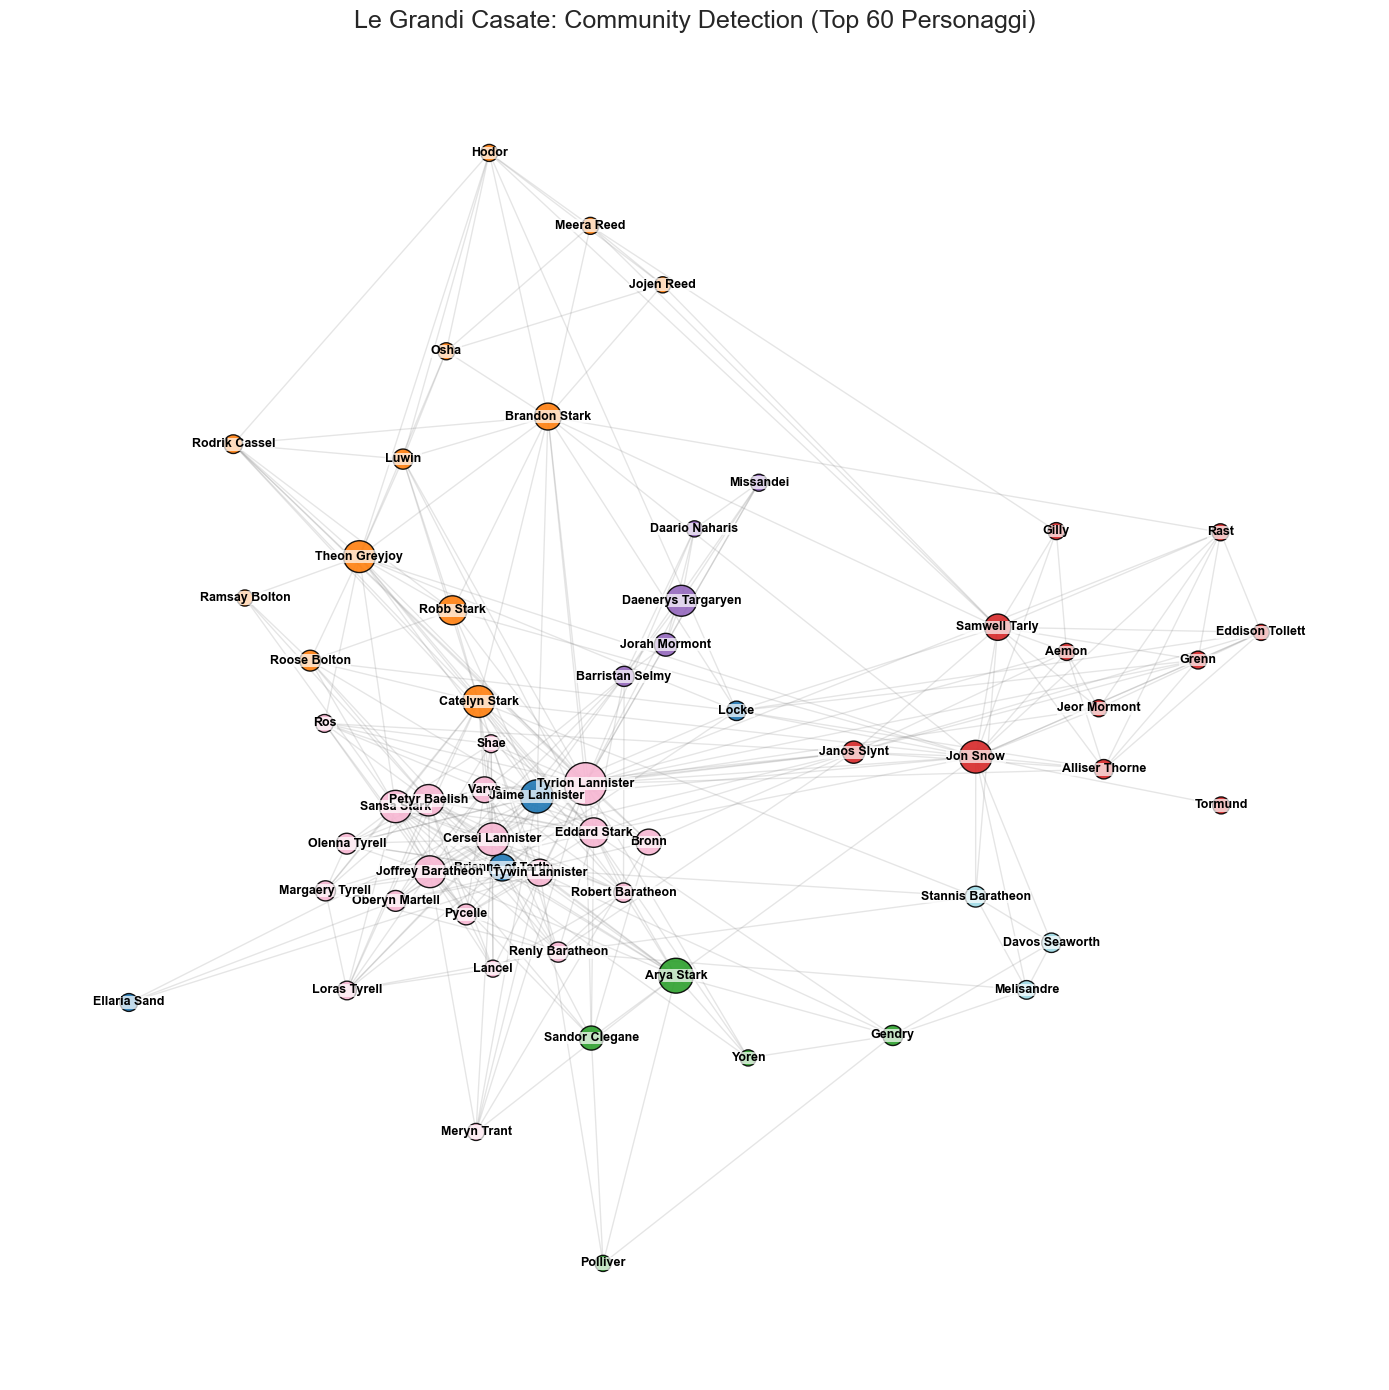

In [9]:
# --- GRAFO 4: COMMUNITY DETECTION (Versione "Clean") ---
plt.figure(figsize=(14, 14))

# 1. CALCOLO SU TUTTI (Per precisione matematica)
# Calcoliamo le comunità sul grafo completo, così Jon Snow finisce nei "Guardiani"
# anche se poi non disegniamo tutte le comparse.
partition = community_louvain.best_partition(G, weight='weight', resolution=1.0)

# 2. FILTRO VISIVO (Il trucco per la pulizia)
# Teniamo solo i primi 60 personaggi per importanza (Degree)
# Puoi cambiare il numero 60 in 50 o 80 se vuoi più/meno dettagli.
sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
top_characters = [n for n, deg in sorted_nodes[:60]]

# Creiamo il sottografo solo per il disegno
subG = G.subgraph(top_characters)

# 3. LAYOUT E COLORI
# Layout calcolato solo sui sopravvissuti (si allargheranno bene)
pos = nx.spring_layout(subG, k=0.3, seed=42, iterations=80, weight='weight')

# Recuperiamo i colori originali delle comunità per questi nodi
cmap = plt.get_cmap('tab20')
node_colors = [partition[n] for n in subG.nodes()]
# Dimensione proporzionale al grado
node_sizes = [G.degree(n) * 15 for n in subG.nodes()]

# 4. DISEGNO
# Archi
nx.draw_networkx_edges(subG, pos, alpha=0.2, edge_color='gray', width=1)

# Nodi
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, cmap=cmap, node_size=node_sizes, 
                       edgecolors='black', linewidths=1, alpha=0.9)

# Etichette (Ora possiamo scriverle tutte o quasi, perché sono pochi nodi)
# Scriviamo i nomi per tutti i 60 personaggi selezionati
nx.draw_networkx_labels(subG, pos, font_size=9, font_weight='bold', font_family='sans-serif',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.3))

plt.title(f"Le Grandi Casate: Community Detection (Top {len(top_characters)} Personaggi)", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
import networkx as nx
import itertools

print("\n🔹 --- FOCUS: ANALISI DELLE TRIADI ---")

# 1. TROVARE TUTTE LE TRIADI
# Un modo efficiente è cercare tutte le "clique" di dimensione 3
# (cioè 3 nodi tutti collegati tra loro)
triangles = [c for c in nx.enumerate_all_cliques(G) if len(c) == 3]

print(f"• Numero totale di triadi (triangoli chiusi) trovate: {len(triangles)}")

# 2. CALCOLARE IL PESO DI OGNI TRIADE
# Il "peso" di una triade è la somma dei pesi dei 3 archi che la compongono.
# Più è alto, più il triangolo è "intenso" (si parlano tantissimo tra loro).

weighted_triads = []

for triangle in triangles:
    u, v, w = triangle
    
    # Prendiamo i pesi dei tre lati
    # Gestiamo il caso in cui 'weight' non esista (mettiamo 1.0 di default)
    w1 = G[u][v].get('weight', 1.0)
    w2 = G[v][w].get('weight', 1.0)
    w3 = G[u][w].get('weight', 1.0)
    
    total_weight = w1 + w2 + w3
    weighted_triads.append((triangle, total_weight))

# 3. ORDINARE E STAMPARE LE TOP 10
# Ordiniamo dal peso più alto al più basso
sorted_triads = sorted(weighted_triads, key=lambda x: x[1], reverse=True)

print("\n🏆 TOP 10 TRIADI PIÙ FORTI (Per somma dei pesi interazioni):")
for i, (members, weight) in enumerate(sorted_triads[:10], 1):
    # Formattazione pulita dei nomi
    names = ", ".join(members)
    print(f"{i}. [{names}] - Peso Totale: {weight:.2f}")

# 4. (Opzionale) ANALISI NARRATIVA VELOCE
# Vediamo se la triade numero 1 è quella che ci aspettiamo (es. Jon, Sam, Grenn o Tyrion, Cersei, Jaime)
top_triad = sorted_triads[0][0]
print(f"\nLa 'Triade di Ferro' della serie è composta da: {', '.join(top_triad)}")


🔹 --- FOCUS: ANALISI DELLE TRIADI ---
• Numero totale di triadi (triangoli chiusi) trovate: 1157

🏆 TOP 10 TRIADI PIÙ FORTI (Per somma dei pesi interazioni):
1. [Tyrion Lannister, Cersei Lannister, Tywin Lannister] - Peso Totale: 2318.43
2. [Tyrion Lannister, Tywin Lannister, Varys] - Peso Totale: 2072.09
3. [Tyrion Lannister, Cersei Lannister, Varys] - Peso Totale: 2066.14
4. [Tyrion Lannister, Cersei Lannister, Jaime Lannister] - Peso Totale: 2059.74
5. [Tyrion Lannister, Daenerys Targaryen, Jorah Mormont] - Peso Totale: 1997.19
6. [Tyrion Lannister, Varys, Shae] - Peso Totale: 1978.30
7. [Tyrion Lannister, Bronn, Varys] - Peso Totale: 1973.76
8. [Tyrion Lannister, Jaime Lannister, Tywin Lannister] - Peso Totale: 1867.15
9. [Tyrion Lannister, Jaime Lannister, Bronn] - Peso Totale: 1828.17
10. [Tyrion Lannister, Tywin Lannister, Shae] - Peso Totale: 1755.09

La 'Triade di Ferro' della serie è composta da: Tyrion Lannister, Cersei Lannister, Tywin Lannister


🔹 --- CONFRONTO ALGORITMI: GIRVAN-NEWMAN ---
Esecuzione Girvan-Newman su 60 nodi...
Girvan-Newman ha suddiviso il grafo in 6 comunità.


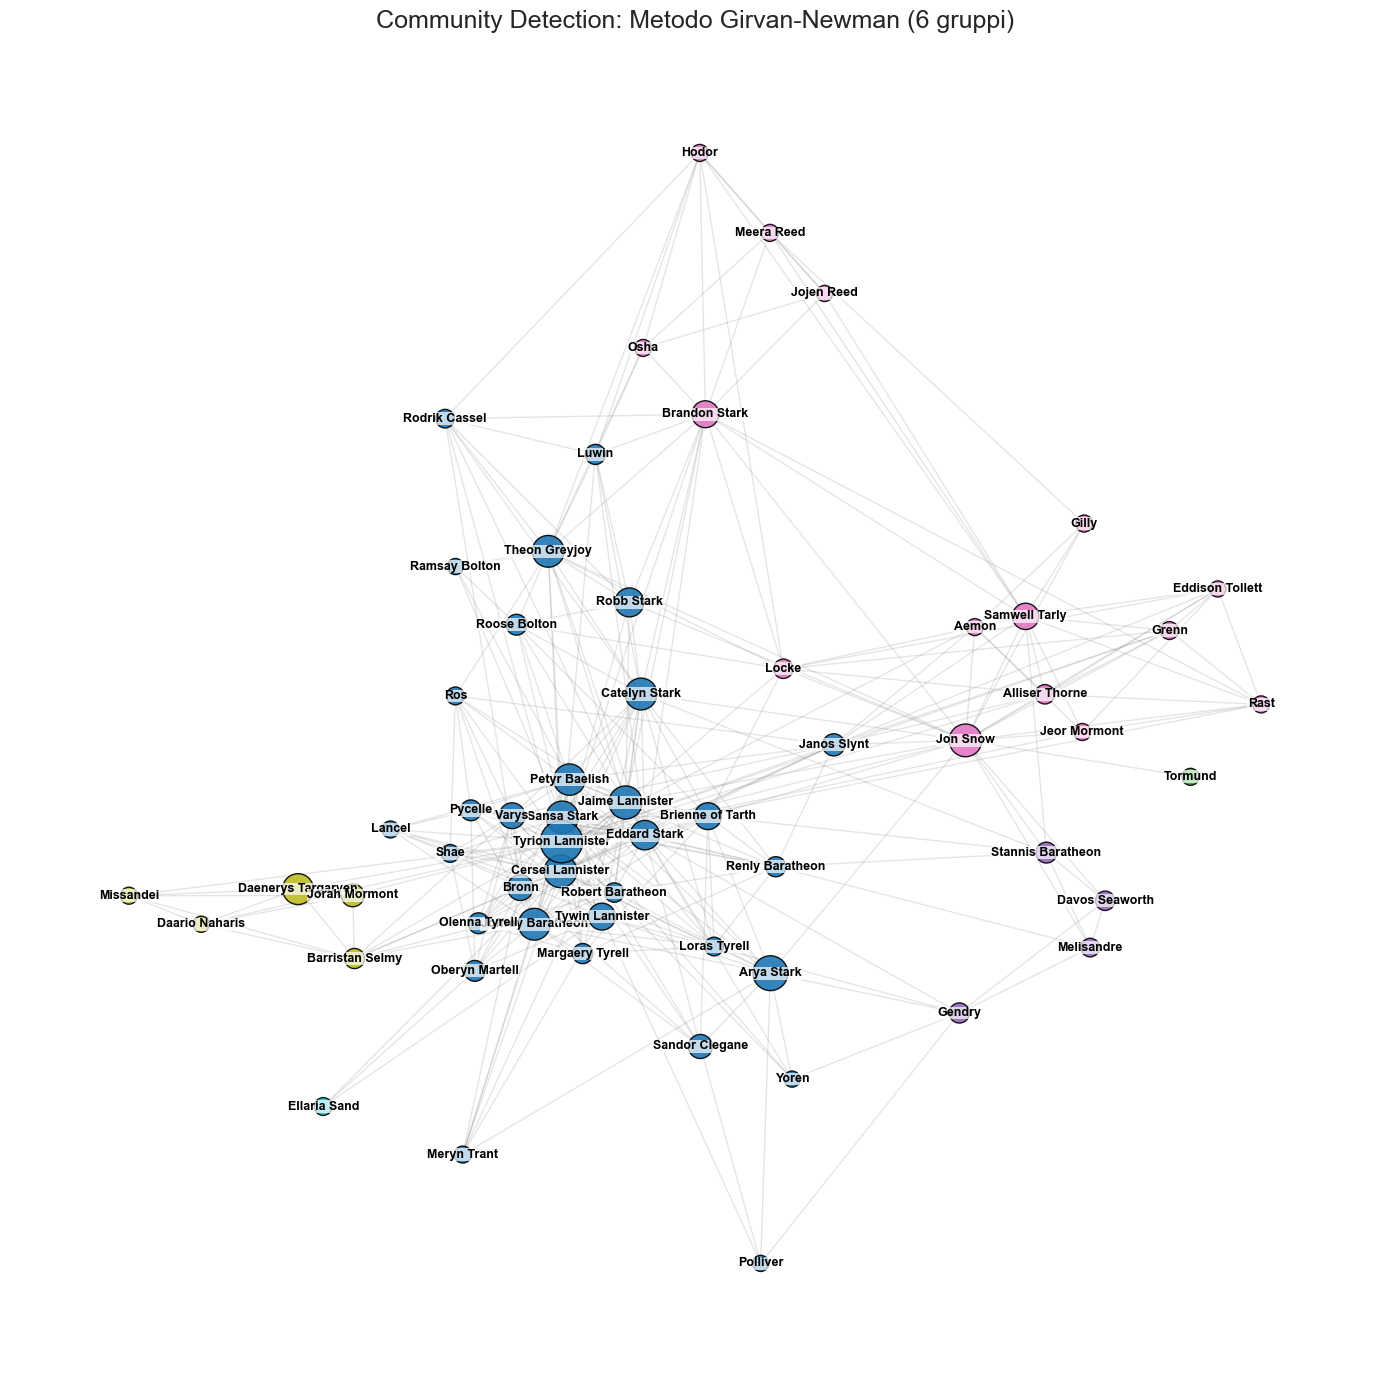

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman

print("🔹 --- CONFRONTO ALGORITMI: GIRVAN-NEWMAN ---")

# 1. PREPARAZIONE SOTTOGRAFO (Top 60)
# Usiamo lo stesso set di dati "pulito" usato per Louvain per un confronto equo
sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
top_characters = [n for n, deg in sorted_nodes[:60]]
subG = G.subgraph(top_characters).copy() # Facciamo una copia per lavorare sicuri

print(f"Esecuzione Girvan-Newman su {len(subG)} nodi...")

# 2. ESECUZIONE ALGORITMO
# Girvan-Newman restituisce un generatore che taglia 1 arco alla volta.
# Noi vogliamo fermarci quando abbiamo un numero ragionevole di comunità (es. 5 o 6 casate)
comp = girvan_newman(subG)

# Iteriamo finché non otteniamo una suddivisione in circa 5-8 comunità
limited_partition = tuple(sorted(c) for c in next(comp)) # Primo livello
# Andiamo avanti qualche step per avere più divisioni (es. livello 3 o 4)
# Nota: Girvan-Newman è un po' lento, quindi prendiamo i primi livelli utili
for communities in comp:
    if len(communities) >= 6: # Ci fermiamo quando troviamo almeno 6 gruppi
        break

print(f"Girvan-Newman ha suddiviso il grafo in {len(communities)} comunità.")

# 3. ASSEGNAZIONE COLORI
# Creiamo una mappa {nodo: id_gruppo}
gn_partition = {}
for idx, group in enumerate(communities):
    for node in group:
        gn_partition[node] = idx

# Generiamo la lista colori
cmap = plt.get_cmap('tab10')
node_colors = [gn_partition[n] for n in subG.nodes()]
node_sizes = [G.degree(n) * 15 for n in subG.nodes()]

# 4. VISUALIZZAZIONE
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(subG, k=0.25, seed=42, iterations=60, weight='weight')

nx.draw_networkx_edges(subG, pos, alpha=0.2, edge_color='gray')
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, cmap=cmap, node_size=node_sizes, 
                       edgecolors='black', linewidths=1, alpha=0.9)

nx.draw_networkx_labels(subG, pos, font_size=9, font_weight='bold', font_family='sans-serif',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.3))

plt.title(f"Community Detection: Metodo Girvan-Newman ({len(communities)} gruppi)", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()